<a href="https://colab.research.google.com/github/olsem1/WP-3/blob/master/KFold_%22LM%2C_Ridge%2C_DT%2C_RF%2C_XGB%2Bneer_cpi_2002_2019%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error


In [2]:
course = pd.read_excel('RC_2002-2020.xlsx')
course = course.rename(columns={"data": "date"})
course = course.set_index('date')
course_m = course.resample('MS').mean()

# **Переменные**

In [3]:
cpi = "year"
reg_names = ['RF']
data_do = "2019-12-01"
train_do = "2019-09-01"

In [4]:
data = pd.read_excel('cpi_reg.xls', sheet_name = cpi)
data = data.set_index('date')
data = data.interpolate(method='polynomial', order=2, axis=0)
data.isna().sum().sum()

0

In [5]:
data.min().min()

99.13

In [ ]:
data.tail(12)

In [7]:
data = data[reg_names]
data = data[:data_do]
data = data.merge(course_m, left_on='date', right_on='date')

data['month'] = pd.DatetimeIndex(data.index).month

In [9]:
data

,RF,curs,month
date,,,
2002-01-01,115.34,30.472715,1
2002-02-01,114.07,30.805700,2
2002-03-01,112.89,31.064267,3
2002-04-01,112.09,31.173586,4
2002-05-01,112.16,31.254884,5
...,...,...,...
2019-08-01,104.31,65.587483,8
2019-09-01,104.03,64.958705,9
2019-10-01,103.76,64.374991,10


# **ARIMAX**

In [10]:
train = data[data.index < train_do]
test = data[data.index >= train_do]


In [11]:
!pip install pmdarima -q
from pmdarima.arima import ADFTest
from pmdarima.arima import auto_arima

     |████████████████████████████████| 1.5MB 6.7MB/s 
     |████████████████████████████████| 9.5MB 27.8MB/s 
     |████████████████████████████████| 2.1MB 53.6MB/s 


In [12]:
exogenous_features = ['month', 'curs']


In [13]:
  # find best params for ARIMA
  stepwise_model = auto_arima(train[reg_names], start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, \
                              d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

"""  stepwise_model = auto_arima(train[reg_names], start_p=1, start_q=1, max_p=3, max_q=3, m=1, start_P=0, seasonal=True, \
                              d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True, \
                              out_of_sample_size = test.shape[0], scoring = 'mse', information_criterion = 'oob')
  
stepwise_model = auto_arima(train_data['cpi_sfo'], start_p=1, start_q=1, max_p=3, max_q=3, m=1, start_P=0, seasonal=True,
                           d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
"""

stepwise_model.fit(train[reg_names])
future_forecast = stepwise_model.predict(n_periods=test.shape[0])
future_forecast = pd.DataFrame(future_forecast, index = test.index, columns=[reg_names])


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.71 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=666.277, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=450.443, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.83 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=557.809, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=414.828, Time=0.48 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.38 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.61 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=538.406, Time=0.28 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=405.169, Time=0.67 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=437.878, Time=0.28 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=4.33 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.54 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=405.503, Time=0.75 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=405.986, Time=

rmse: 0.3608
normed rmse: 0.3486%


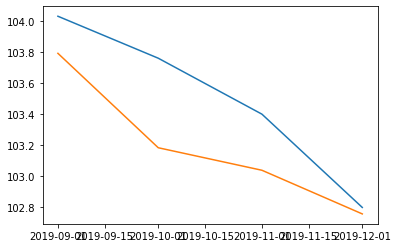

In [14]:
plt.plot(test[reg_names])
plt.plot(future_forecast[reg_names])

print('rmse: {:.4f}'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5))
print('normed rmse: {:.4f}%'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5 / 
                                    np.mean(test[reg_names].values) * 100))

In [15]:
# find best params for ARIMAX
stepwise_model = auto_arima(train[reg_names], exogenous = train[exogenous_features], start_p=1, start_q=1, 
                            max_p=4, max_q=4, m=12, start_P=0, seasonal=True,
                            d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
  
stepwise_model.fit(train[reg_names], exogenous = train[exogenous_features])
future_forecast = stepwise_model.predict(n_periods=test.shape[0], exogenous = test[exogenous_features])
future_forecast = pd.DataFrame(future_forecast, index = test.index, columns=[reg_names])

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.63 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=668.588, Time=0.16 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=452.909, Time=0.77 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.34 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=561.794, Time=0.13 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=416.865, Time=1.52 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=4.31 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.93 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=533.016, Time=0.79 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=408.444, Time=2.10 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=441.575, Time=0.96 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=10.47 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.49 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=408.735, Time=2.01 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=409.263, Time

rmse: 0.2223
normed rmse: 0.2148%


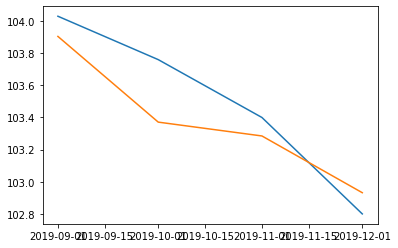

In [16]:
plt.plot(test[reg_names])
plt.plot(future_forecast[reg_names])

print('rmse: {:.4f}'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5))
print('normed rmse: {:.4f}%'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5 / 
                                    np.mean(test[reg_names].values) * 100))

In [ ]:
data_lags = pd.DataFrame()

#data_lags['curs-2'] = data['curs'].shift(2).values
data_lags['curs-1'] = data['curs'].shift(1).values
data_lags['curs'] = data['curs'].values
data_lags['t'] = data[reg_names].values
for i in range(1, 13):
    data_lags['t-'+str(i)] = data[reg_names].shift(i).values
    
data_lags.index = data.index
data_lags = data_lags[12:]
data_lags['month'] = pd.DatetimeIndex(data_lags.index).month
data_lags

In [18]:
data = data_lags
data_not = data.drop('t', axis=1)
train = data[data.index < train_do]
test = data[data.index >= train_do]

X_train = train[['month'] + ['curs'] + ['curs-1'] + ['t-{}'.format(month) for month in range(1,13)]].values
y_train = train[['t']].values.ravel()
X_test = test[['month'] + ['curs'] + ['curs-1'] + ['t-{}'.format(month) for month in range(1,13)]].values
y_test = test[['t']].values.ravel()

# **KNeighborsRegressor**

In [19]:
!pip install mglearn -q

     |████████████████████████████████| 542kB 6.3MB/s 


In [20]:
from sklearn.datasets import make_blobs
import mglearn
from sklearn.neighbors import KNeighborsRegressor

# instantiate the model 
KNmodel = KNeighborsRegressor(n_neighbors=7)
# fit the model using the training data and training targets
KNmodel.fit(X_train, y_train)

print("Training set score: {:.2f}".format(KNmodel.score(X_train, y_train)))
print("Test set score: {:.2f}".format(KNmodel.score(X_test, y_test)))

forecast = KNmodel.predict(X_test)
print('rmse: {:.4f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.91
Test set score: -0.23
rmse: 0.5111
normed rmse: 0.4939%


# **OLS**

In [21]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

forecast = lr.predict(X_test)
print('rmse: {:.4f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.98
Test set score: 0.93
rmse: 0.1225
normed rmse: 0.1183%


# **Ridge (l2-regularisation)**

In [22]:
from sklearn.linear_model import Ridge

ridge = Ridge().fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge.score(X_test, y_test)))

forecast = ridge.predict(X_test)
print('rmse: {:.2f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.98
Test set score: 0.94
rmse: 0.11
normed rmse: 0.11%


In [23]:
ridge10 = Ridge(alpha=10).fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge10.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge10.score(X_test, y_test)))

forecast = ridge10.predict(X_test)
print('rmse: {:.2f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.98
Test set score: 0.80
rmse: 0.21
normed rmse: 0.20%


In [24]:
ridge01 = Ridge(alpha=0.1).fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge01.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge01.score(X_test, y_test)))

forecast = ridge10.predict(X_test)
print('rmse: {:.2f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.98
Test set score: 0.93
rmse: 0.21
normed rmse: 0.20%


# **Lasso (l1-regularisation)**

In [25]:
from sklearn.linear_model import Lasso

lasso = Lasso().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso.coef_ != 0))

forecast = lasso.predict(X_test)
print('rmse: {:.2f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.95
Test set score: -1.08
Number of features used: 2
rmse: 0.66
normed rmse: 0.64%


In [26]:
# we increase the default setting of "max_iter",
# otherwise the model would warn us that we should increase max_iter.
lasso001 = Lasso(alpha=0.01, max_iter=100000).fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso001.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso001.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso001.coef_ != 0))

forecast = lasso001.predict(X_test)
print('rmse: {:.2f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.98
Test set score: 0.88
Number of features used: 10
rmse: 0.16
normed rmse: 0.15%


# **ElasticNet (l1+l2-regularisation)**

In [27]:
from sklearn.linear_model import ElasticNet
ENmodel = ElasticNet(alpha=0.01, max_iter=100000, random_state=0)
ENmodel.fit(X_train, y_train)
print("Training set score: {:.2f}".format(ENmodel.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ENmodel.score(X_test, y_test)))
print("Number of features used:", np.sum(ENmodel.coef_ != 0))

forecast = ENmodel.predict(X_test)
print('rmse: {:.2f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.98
Test set score: 0.91
Number of features used: 12
rmse: 0.14
normed rmse: 0.14%


# **DecisionTree**

In [28]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=2, random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

forecast = tree.predict(X_test)
print('rmse: {:.2f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Accuracy on training set: 0.880
Accuracy on test set: -0.256
rmse: 0.52
normed rmse: 0.50%


# **Random Forest**

rmse: 0.425
normed rmse: 0.411%
Accuracy on training set: 0.994
Accuracy on test set: 0.147


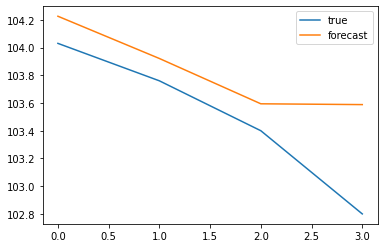

In [31]:
from sklearn.ensemble import RandomForestRegressor

RFmodel = RandomForestRegressor(n_estimators=500, random_state=42)
RFmodel.fit(X_train, y_train)
forecast = RFmodel.predict(X_test)

plt.plot(y_test, label='true')
plt.plot(forecast, label='forecast')
plt.legend()

print('rmse: {:.3f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.3f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / 
                                    np.mean(y_test) * 100))

print("Accuracy on training set: {:.3f}".format(RFmodel.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(RFmodel.score(X_test, y_test)))

In [32]:
RFmodel.feature_importances_

array([0.00214508, 0.00568952, 0.00705665, 0.95557058, 0.00343726,
       0.00210835, 0.0017398 , 0.00178774, 0.00247126, 0.00336942,
       0.00162231, 0.00144287, 0.00199215, 0.00242439, 0.00714261])

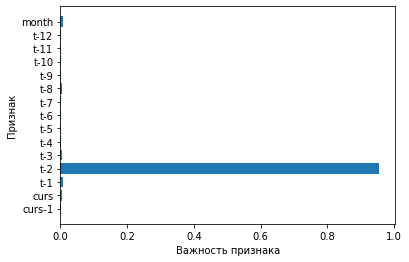

In [33]:
def plot_features(model):
  n_features = data_not.shape[1]
  plt.barh(range(n_features), model.feature_importances_, align='center')
  plt.yticks(np.arange(n_features), data_not.columns)
  plt.xlabel('Важность признака')
  plt.ylabel('Признак')
plot_features(RFmodel)

# **Кроссвалидация**

In [34]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(RFmodel, X_train, y_train, cv=3)
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Cross-validation scores: [0.90897447 0.92997813 0.82368727]
Average cross-validation score: 0.89


In [35]:
from sklearn.model_selection import cross_validate
res = cross_validate(RFmodel, X_train, y_train, cv=4,
                     return_train_score=True)
display(res)

{'fit_time': array([0.93266606, 0.88958216, 0.88947535, 0.907125  ]),
 'score_time': array([0.0281198 , 0.0286479 , 0.02873039, 0.02788758]),
 'test_score': array([0.8090907 , 0.93063693, 0.90877959, 0.81217418]),
 'train_score': array([0.99475159, 0.9926727 , 0.99510009, 0.99325156])}

In [36]:
res_df = pd.DataFrame(res)
display(res_df)
print("Mean times and scores:\n", res_df.mean())

,fit_time,score_time,test_score,train_score
0,0.932666,0.028120,0.809091,0.994752
1,0.889582,0.028648,0.930637,0.992673
2,0.889475,0.028730,0.908780,0.995100
3,0.907125,0.027888,0.812174,0.993252


Mean times and scores:
 fit_time       0.904712
score_time     0.028346
test_score     0.865170
train_score    0.993944
dtype: float64


# **Slide test**

In [37]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
#startdate = pd.to_datetime(data_do)
startdate = pd.to_datetime(train_do)+ relativedelta(months=1)

#print('Today: ', startdate.strftime('%Y-%m-%d'))
#print(date_after_month.strftime('%Y-%m-%d'))
#startdate = str(startdate)[:10]
startdate

Timestamp('2019-10-01 00:00:00')

rmse: 1.1314
normed rmse: 1.0931%


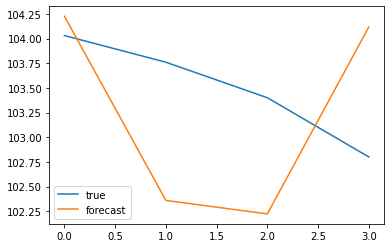

In [39]:
#forecast = RFmodel.predict(X_test)
#slide_test = test[test.index == train_do][data_not.columns.values].values
#print(slide_test)
slide_test = X_test
forecast = []
forecast.append(RFmodel.predict(slide_test)[0])

for i in range(test.shape[0] - 1):
  
  slide_test_next = slide_test.copy()
  slide_test_next[0, 1] = forecast[-1]

  slide_test_next[0, 0] += 1
  slide_test_next[0, 2:] = slide_test[0, 1:-1]
  
  #print(slide_test_next)
  slide_test = slide_test_next.copy()

  forecast.append(RFmodel.predict(slide_test)[0])

forecast = np.array(forecast)

plt.plot(y_test, label='true')
plt.plot(forecast, label='forecast')
plt.legend()

print('rmse: {:.4f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format((mean_squared_error(y_test, forecast) ** 0.5) / np.mean(y_test) * 100))


# **KFold cross validation**

In [40]:
#!pip install mglearn -q
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import mglearn


In [41]:
%%time
model = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=1)
#model.fit(X_train, y_train)

scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.58556953 0.90867979 0.83882082 0.78766715 0.2417129 ]
CPU times: user 456 ms, sys: 981 µs, total: 457 ms
Wall time: 464 ms


In [42]:
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Average cross-validation score: 0.67


# **Stratified K-Fold cross-validation and other strategies**

In [43]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=3)

In [44]:
print("Cross-validation scores:\n{}".format(
      cross_val_score(model, X_train, y_train, cv=kfold)))

Cross-validation scores:
[0.90253105 0.92674871 0.84084992]


In [45]:
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
print("Cross-validation scores:\n{}".format(
    cross_val_score(model, X_train, y_train, cv=kfold)))

Cross-validation scores:
[0.96507139 0.90454448 0.95774674]


# **GradientBoostingRegressor**

In [46]:
from xgboost import XGBRegressor

[02:39:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rmse: 0.2301
normed rmse: 0.2224%
Accuracy on training set: 1.000
Accuracy on test set: 0.750


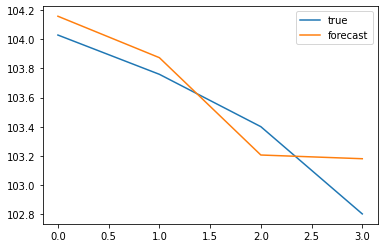

In [47]:
xgb_model = XGBRegressor(n_estimators=10000, learning_rate=0.01, max_depth=3)
xgb_model.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_train, y_train)], verbose=False)
# make predictions
xgb_forecast = xgb_model.predict(X_test)
xgb_model.feature_importances_
plt.plot(y_test, label='true')
plt.plot(xgb_forecast, label='forecast')
plt.legend()

from sklearn.metrics import mean_squared_error
print('rmse: {:.4f}'.format(mean_squared_error(y_test, xgb_forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format((mean_squared_error(y_test, xgb_forecast) ** 0.5) / 
                                    np.mean(y_test) * 100))

print("Accuracy on training set: {:.3f}".format(xgb_model.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(xgb_model.score(X_test, y_test)))

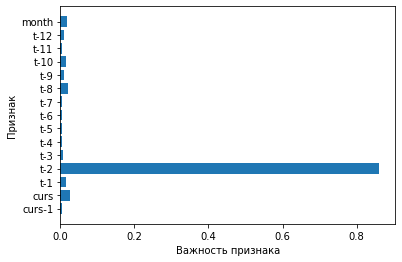

In [48]:
def plot_features(model):
  n_features = data_not.shape[1]
  plt.barh(range(n_features), model.feature_importances_, align='center')
  plt.yticks(np.arange(n_features), data_not.columns)
  plt.xlabel('Важность признака')
  plt.ylabel('Признак')
plot_features(xgb_model)